# DDoS Network Intrusion Detection and Classification

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Lasso

In [5]:
pwd

'/Users/karlamuller/my_notebooks'

In [6]:
# This extension for sound notification and cell completion time
get_ipython().magic('load_ext cellevents')

In [7]:
# Loading data for MSSQL, LDAP, NetBIOS, Syn and UDP attacks 
df_mssql = pd.read_csv('mydata/01-12/DrDoS_MSSQL.csv')
df_ldap = pd.read_csv('mydata/01-12/DrDoS_LDAP.csv')
df_netbios = pd.read_csv('mydata/01-12/DrDoS_NetBIOS.csv')
df_syn = pd.read_csv('mydata/01-12/Syn.csv')
df_udp = pd.read_csv('mydata/01-12/DrDoS_UDP.csv')

time: 2min 11s


## Creating main dataframe with all attacks

In [8]:
# Checking for class inbalance
print(df_mssql[' Label'].value_counts())
print(df_ldap[' Label'].value_counts())
print(df_netbios[' Label'].value_counts())
print(df_syn[' Label'].value_counts())
print(df_udp[' Label'].value_counts())

DrDoS_MSSQL    4522492
BENIGN            2006
Name:  Label, dtype: int64
DrDoS_LDAP    2179930
BENIGN           1612
Name:  Label, dtype: int64
DrDoS_NetBIOS    4093279
BENIGN              1707
Name:  Label, dtype: int64
Syn       1582289
BENIGN        392
Name:  Label, dtype: int64
DrDoS_UDP    3134645
BENIGN          2157
Name:  Label, dtype: int64
time: 1.35 s


In [9]:
# Due to high imbalance, creating a dataframe for benign connections
good_frames = [df_mssql[df_mssql[' Label'] == 'BENIGN'], 
          df_syn[df_syn[' Label'] == 'BENIGN'],
          df_netbios[df_netbios[' Label'] == 'BENIGN'],
          df_ldap[df_ldap[' Label'] == 'BENIGN'],
          df_udp[df_udp[' Label'] == 'BENIGN']]

df_benign = pd.concat(good_frames)

time: 4.38 s


In [10]:
df_benign.shape

(7874, 88)

time: 3.6 ms


In [11]:
# Subsampling 20% of the datasets with attacks only
df_mssql = pd.DataFrame.sample(
        df_mssql[df_mssql[' Label'] == 'DrDoS_MSSQL'], frac=0.2, replace=True )


df_ldap = pd.DataFrame.sample(
        df_ldap[df_ldap[' Label'] == 'DrDoS_LDAP'], frac=0.2, replace=True )

df_netbios = pd.DataFrame.sample(
        df_netbios[df_netbios[' Label'] == 'DrDoS_NetBIOS'], frac=0.2, replace=True )


df_syn =  pd.DataFrame.sample(
        df_syn[df_syn[' Label'] == 'Syn'], frac=0.2, replace=True )

df_udp = pd.DataFrame.sample(
        df_udp[df_udp[' Label'] == 'DrDoS_UDP'], frac=0.2, replace=True )

time: 54.1 s


In [12]:
# Joining all datasets  and shuffling them
dfList = [df_mssql, df_ldap, df_netbios, df_syn, df_udp, df_benign]
all_df = pd.concat(dfList,ignore_index=True)
all_df = all_df.sample(frac=1)

time: 51.4 s


In [13]:
# Creating an all df for easy future loads
all_df.to_csv('/Users/karlamuller/my_notebooks/mydata/all_df.csv')

time: 3min 43s


In [14]:
pwd

'/Users/karlamuller/my_notebooks'

time: 14.8 ms


In [59]:
all_df = pd.read_csv('mydata/all_df.csv')

time: 51.7 s


### EDA

In [60]:
all_df.head(2)

,Unnamed: 0,Unnamed: 0.1,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,1442623,122373,172.16.0.5-192.168.50.1-573-20325-17,172.16.0.5,573,192.168.50.1,20325,17,2018-12-01 11:52:07.287572,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NetBIOS
1,2176913,156600,172.16.0.5-192.168.50.1-7428-28662-6,172.16.0.5,7428,192.168.50.1,28662,6,2018-12-01 13:33:40.722479,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn


time: 51.2 ms


In [61]:
all_df.shape

(3110401, 89)

time: 4.27 ms


In [62]:
# Classification labels for dependent variable 
all_df[' Label'].unique()

array(['DrDoS_NetBIOS', 'Syn', 'DrDoS_MSSQL', 'DrDoS_LDAP', 'DrDoS_UDP',
       'BENIGN'], dtype=object)

time: 137 ms


In [63]:
# Assigning numeric values for classification variable 
all_df = all_df.replace({' Label': {'DrDoS_MSSQL':1, 'DrDoS_LDAP':2, 'DrDoS_NetBIOS':3, 'Syn':4,
       'DrDoS_UDP':5, 'BENIGN':0}})

time: 4.47 s


In [64]:
# Converting to type int
all_df[' Label'].astype(int)
pd.set_option('display.min_rows', None)

time: 8.02 ms


In [65]:
# Verifying conversion
all_df[' Label'].unique()

array([3, 4, 1, 2, 5, 0])

time: 26.4 ms


In [66]:
# Checking unbalanced data
all_df[' Label'].value_counts()

1    904498
3    818656
5    626929
2    435986
4    316458
0      7874
Name:  Label, dtype: int64

time: 38.6 ms


In [67]:
# Finding datatypes
pd.set_option('display.max_rows', None)
all_df.dtypes

Unnamed: 0                        int64
Unnamed: 0.1                      int64
Flow ID                          object
 Source IP                       object
 Source Port                      int64
 Destination IP                  object
 Destination Port                 int64
 Protocol                         int64
 Timestamp                       object
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets     float64
 Total Length of Bwd Packets    float64
 Fwd Packet Length Max          float64
 Fwd Packet Length Min          float64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max           float64
 Bwd Packet Length Min          float64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                     object
 Flow Packets/s                  object
 Flow IAT Mean                  float64


time: 7.76 ms


In [68]:
# Dropping non numeric identifiers 
all_df = all_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Flow ID', ' Source IP', ' Timestamp',
       ' Destination IP', 'SimillarHTTP', ' Destination Port', ' Source Port'])

time: 6.34 s


In [69]:
all_df.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
count,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,...,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06,3.110401e+06
mean,1.586012e+01,8.660452e+05,2.971404e+00,4.465437e-02,1.147056e+03,5.439786e+00,5.126488e+02,5.065258e+02,5.092277e+02,3.179030e+00,...,3.714000e+02,5.153309e+02,1.251370e+03,1.254645e+02,1.675362e+05,5.497765e+04,2.480870e+05,1.130944e+05,9.975643e-01,2.775499e+00
std,3.354492e+00,9.037330e+06,2.015912e+02,1.006398e+00,1.033624e+03,1.277540e+03,4.430000e+02,4.449097e+02,4.438702e+02,1.136444e+01,...,2.801840e+04,2.765885e+04,6.447878e+04,2.378478e+04,1.848928e+06,7.001081e+05,2.733419e+06,1.339314e+06,4.929267e-02,1.477742e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.700000e+01,1.000000e+00,2.000000e+00,0.000000e+00,4.580000e+02,0.000000e+00,2.290000e+02,2.290000e+02,2.290000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,1.700000e+01,1.000000e+00,2.000000e+00,0.000000e+00,8.360000e+02,0.000000e+00,3.930000e+02,3.830000e+02,3.830000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
75%,1.700000e+01,2.000000e+00,2.000000e+00,0.000000e+00,1.438000e+03,0.000000e+00,5.500000e+02,5.500000e+02,5.500000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00
max,1.700000e+01,1.199330e+08,8.622100e+04,8.170000e+02,6.931000e+04,1.468048e+06,3.547000e+03,1.472000e+03,1.895333e+03,1.271117e+03,...,1.402356e+07,5.081857e+06,1.402356e+07,1.402356e+07,1.146333e+08,5.597064e+07,1.146333e+08,1.146333e+08,1.000000e+00,5.000000e+00


time: 9.98 s


In [70]:
# Converting flow packets to float (was object)
all_df[' Flow Packets/s']= all_df[' Flow Packets/s'].astype(float)
# Converting flow bytes to float (was object)
all_df['Flow Bytes/s']= all_df['Flow Bytes/s'].astype(float)

time: 806 ms


In [71]:
# Maximum value 
all_df[' Flow Packets/s'].max()

inf

time: 23.1 ms


In [72]:
# Number of infinity values 
all_df[' Flow Packets/s'].loc[all_df[' Flow Packets/s'] == np.inf].count()

107497

time: 16.4 ms


In [73]:
# Maximum value 
all_df['Flow Bytes/s'].max()

inf

time: 21.2 ms


In [74]:
# Number of infinity values 
all_df['Flow Bytes/s'].loc[all_df['Flow Bytes/s'] == np.inf].count()

66874

time: 8.82 ms


In [75]:
# Finding nans
all_df[' Flow Packets/s'].isna().sum()

0

time: 6.92 ms


In [76]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

40623

time: 7.16 ms


In [77]:
# Finding max value thats not infinity and assigning it to inf
max_bytes = all_df.loc[all_df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
all_df['Flow Bytes/s'].replace(np.inf,max_bytes,inplace=True)

time: 58.4 ms


In [78]:
# Finding max value thats not infinity and assigning it to inf
max_packets = all_df.loc[all_df[' Flow Packets/s'] != np.inf, ' Flow Packets/s'].max()
all_df[' Flow Packets/s'].replace(np.inf,max_packets,inplace=True)

time: 34.9 ms


In [79]:
# Finding nans
all_df[' Flow Packets/s'].isna().sum()

0

time: 8.25 ms


In [80]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

40623

time: 8.46 ms


In [81]:
# 'Flow Bytes/s' has all of dfs nans
pd.set_option('display.max_rows', None)
all_df.isna().sum()

 Protocol                           0
 Flow Duration                      0
 Total Fwd Packets                  0
 Total Backward Packets             0
Total Length of Fwd Packets         0
 Total Length of Bwd Packets        0
 Fwd Packet Length Max              0
 Fwd Packet Length Min              0
 Fwd Packet Length Mean             0
 Fwd Packet Length Std              0
Bwd Packet Length Max               0
 Bwd Packet Length Min              0
 Bwd Packet Length Mean             0
 Bwd Packet Length Std              0
Flow Bytes/s                    40623
 Flow Packets/s                     0
 Flow IAT Mean                      0
 Flow IAT Std                       0
 Flow IAT Max                       0
 Flow IAT Min                       0
Fwd IAT Total                       0
 Fwd IAT Mean                       0
 Fwd IAT Std                        0
 Fwd IAT Max                        0
 Fwd IAT Min                        0
Bwd IAT Total                       0
 Bwd IAT Mea

time: 1.85 s


In [82]:
# 'Flow Bytes/s' quick stats
all_df['Flow Bytes/s'].describe()

count    3.069778e+06
mean     8.309448e+08
std      9.003809e+08
min      0.000000e+00
25%      1.861618e+07
50%      4.580000e+08
75%      1.056000e+09
max      2.944000e+09
Name: Flow Bytes/s, dtype: float64

time: 105 ms


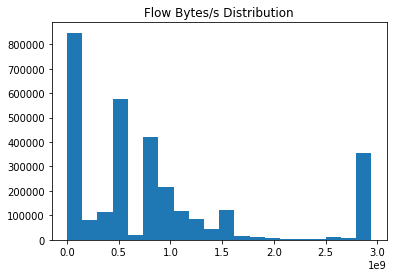

time: 385 ms


In [83]:
# 'Flow Bytes/s' distribution
plt.figure()
plt.hist(all_df['Flow Bytes/s'], bins=20)
plt.title('Flow Bytes/s Distribution')
plt.show()

In [84]:
# Which class has null values
g = all_df.groupby(' Label')
g = g.count().rsub(g.size(), axis=0)
g['Flow Bytes/s']

 Label
0       32
1        0
2        0
3        1
4    40590
5        0
Name: Flow Bytes/s, dtype: int64

time: 3.99 s


In [85]:
# This takes a bit
# Filling nans with medians of each class
all_df['Flow Bytes/s'] = all_df.groupby(" Label").transform(lambda x: x.fillna(x.median()))

time: 31.6 s


In [86]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

0

time: 12.4 ms


In [87]:
all_df.isna().sum()

 Protocol                       0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max                    0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean                   0
 Bwd IAT Std                    0
 Bwd IAT Max                    0
 Bwd IAT Min  

time: 1.87 s


### Assigning variables for Lasso Regression

In [88]:
# Shuffling rows 
all_df = all_df.sample(frac=1)

time: 4.42 s


In [89]:
# Defining my variables 
X = all_df.iloc[:,:-1]
y = all_df.iloc[:,-1]

time: 1.18 s


In [90]:
# Applying Lasso regression
lasso_all_df = Lasso()
lasso_all_df.fit(X,y)

lasso_all_df.coef_

array([-0.00000000e+00,  9.82758652e-09, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  6.30338161e-06,  1.76870480e-03, -0.00000000e+00,
        0.00000000e+00,  2.30758438e-03, -1.45461250e-03, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.24368365e-07,
        9.21463077e-08,  1.35156513e-07,  2.41115672e-08, -1.86095626e-07,
       -1.11689956e-08,  9.55845081e-08,  2.64494276e-08,  7.59687442e-08,
       -3.64847381e-07, -4.23683826e-08,  4.62131214e-08, -1.63507588e-07,
        1.22177312e-07, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.64025503e-11,  1.56580826e-09,
       -1.71419964e-07, -2.74507721e-06, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.91550950e-03, -1.12151877e-05,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -6.52698802e-03,  

time: 3min 11s


In [91]:
# Creating dataframe for lasso coeffs
a = [X.columns, lasso_all_df.coef_]
df_lasso = pd.DataFrame(a).T


time: 41.5 ms


In [92]:
# Renaming columns
df_lasso = df_lasso.rename(columns={0:'variables', 1:'coeff'})

time: 10.6 ms


In [93]:
# Sorting 
df_lasso.sort_values(by='coeff', ascending=False)

,variables,coeff
41,Packet Length Std,0.00691551
53,Avg Fwd Segment Size,0.00654496
9,Fwd Packet Length Std,0.00230758
6,Fwd Packet Length Max,0.0017687
63,Subflow Fwd Bytes,0.000198674
66,Init_Win_bytes_forward,0.000109322
5,Total Length of Bwd Packets,6.30338e-06
71,Active Std,1.14816e-06
73,Active Min,2.94456e-07
17,Flow IAT Std,1.35157e-07


time: 25.6 ms


In [94]:
# Assignig zero coefficients 
zero_coeffs = df_lasso[df_lasso.coeff == 0]

time: 5.48 ms


In [95]:
zero_coeffs['variables'].values

array([' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       'Flow Bytes/s', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' ECE Flag Count', ' Down/Up Ratio', ' Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Inbound'],
      dtype=object)

time: 2.21 ms


In [96]:
# Dropping variables with zero coefficient
all_df = all_df.drop(columns=[' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       'Flow Bytes/s', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' ECE Flag Count', ' Down/Up Ratio', ' Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Packets', ' Subflow Bwd Packets',
       ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Inbound'])

time: 2.1 s


In [97]:
all_df.shape

(3110401, 41)

time: 2.16 ms


In [98]:
# Finding top coefficients 
df_lasso = df_lasso.sort_values(by="coeff", ascending=False)
df_lasso.head(5)

,variables,coeff
41,Packet Length Std,0.00691551
53,Avg Fwd Segment Size,0.00654496
9,Fwd Packet Length Std,0.00230758
6,Fwd Packet Length Max,0.0017687
63,Subflow Fwd Bytes,0.000198674


time: 7.05 ms


In [99]:
# Generating a csv file for easy access to cleaned data
all_df.to_csv('/Users/karlamuller/my_notebooks/mydata/ddos_clean.csv')

time: 1min 27s


In [100]:
all_df.head()

,Flow Duration,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2806495,1,0.0,229.0,0.0,0.0,2000000.0,1.0,0.0,1.0,1.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
89556,1,0.0,229.0,0.0,0.0,2000000.0,1.0,0.0,1.0,1.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
424776,1,0.0,229.0,0.0,0.0,2000000.0,1.0,0.0,1.0,1.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1162152,1,0.0,483.0,0.0,0.0,2000000.0,1.0,0.0,1.0,1.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
67666,1,0.0,1472.0,0.0,0.0,2000000.0,1.0,0.0,1.0,1.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


time: 22.8 ms
